# Задача: Анализ эффективности нового алгоритма рекомендаций в условиях асимметричного и зашумленного распределения
### Контекст:
Крупная стриминговая платформа (аналог YouTube или Twitch) разработала новый алгоритм рекомендаций контента (алгоритм B), который, как ожидается, должен увеличить среднее время просмотра на пользователя по сравнению со старым алгоритмом (A).

Было проведено A/B-тестирование:

- **Группа A (Контрольная)**: 5000 пользователей, старый алгоритм.

- **Группа B (Тестовая)**: 5000 пользователей, новый алгоритм.

По итогам двухнедельного теста вы собрали данные по ключевой метрике — **«Общее время просмотра на пользователя за тест (в минутах)»**.

**Данные и их особенности:**

**Не нормальность:** Распределение метрики в обеих группах сильно отличается от нормального. Оно имеет типичный для поведенческих данных "длинный хвост":

- Большинство пользователей смотрят немного (пик в районе 0-50 минут).

- Небольшая группа "супер-зрителей" смотрит очень много (сотни и тысячи минут), формируя длинный правый хвост распределения.

**Асимметрия влияния:** Новый алгоритм B целенаправленно меняет опыт именно активных пользователей, в то время как для "пассивных" зрителей разница неочевидна. Это означает, что различие между группами может быть не сдвигом всего распределения, а изменением в правом хвосте.

**Наличие выбросов:** В данных присутствуют экстремальные выбросы (например, пользователи, которые оставляли видео фоном на всю ночь).

Вам предоставлен датасет _ab_test_results.csv_ со следующими колонками:

 - _user_id_

 - _group (A или B)_

 - _total_watch_time_min_

### Задания:


- **Проведите тест Манна-Уитни (Mann-Whitney U test)**. Сформулируйте нулевую и альтернативную гипотезы. Интерпретируйте p-value. Можно ли на его основе сделать однозначный вывод о превосходстве алгоритма B?

- Чтобы исследовать "асимметричное влияние", проведите анализ разниц не только в центре распределения, но и в хвостах. **Рассчитайте и визуализируйте разницу между группами для 75-го, 90-го и 95-го процентилей**.

- **Сформулируйте итоговый вывод:**

    - Эффективен ли новый алгоритм B?

    - На какую именно группу пользователей он оказывает наибольшее влияние?

    - Какой метод анализа оказался наиболее информативным в данном случае и почему?

    - Дайте рекомендацию о возможности запуска алгоритма на всю аудиторию.



In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [12]:
# Load CSV
df = pd.read_csv('ab_test_results.csv')

group_a_data = df[df['group'] == 'A']['total_watch_time_min']
group_b_data = df[df['group'] == 'B']['total_watch_time_min']

# Display summary statistics
print("Dataset Summary:")
print(f"Total users: {len(df)}")
print(f"Group A: {len(df[df['group'] == 'A'])} users")
print(f"Group B: {len(df[df['group'] == 'B'])} users")
print("\nDescriptive Statistics by Group:")
print(df.groupby('group')['total_watch_time_min'].describe())

print("\nKey Percentiles by Group:")
percentiles = [0.75, 0.9, 0.95]
diffs = []
for p in percentiles:
    p_val = p * 100
    a_val = np.percentile(group_a_data, p_val)
    b_val = np.percentile(group_b_data, p_val)
    diff = b_val - a_val
    diffs.append(diff)
    print(f"{p_val:.0f}th percentile: A={a_val:.1f}, B={b_val:.1f}, Difference={diff:.1f}")

# Test the differences
from scipy import stats
mw_stat, mw_p = stats.mannwhitneyu(
    group_a_data,
    group_b_data,
    alternative= 'two-sided' #'less' #'greater' #'two-sided'
)

print(f"\nMann-Whitney U Test: p-value = {mw_p:.6f}")

Dataset Summary:
Total users: 10000
Group A: 5000 users
Group B: 5000 users

Descriptive Statistics by Group:
        count       mean         std  min        25%        50%        75%  \
group                                                                        
A      5000.0  56.347878  262.313288  0.0  14.729144  26.834960  44.946309   
B      5000.0  71.477408  408.519252  0.0  15.383838  27.352416  46.352279   

                max  
group                
A       8130.547119  
B      11670.621483  

Key Percentiles by Group:
75th percentile: A=44.9, B=46.4, Difference=1.4
90th percentile: A=71.5, B=76.2, Difference=4.7
95th percentile: A=119.3, B=153.6, Difference=34.3

Mann-Whitney U Test: p-value = 0.045342


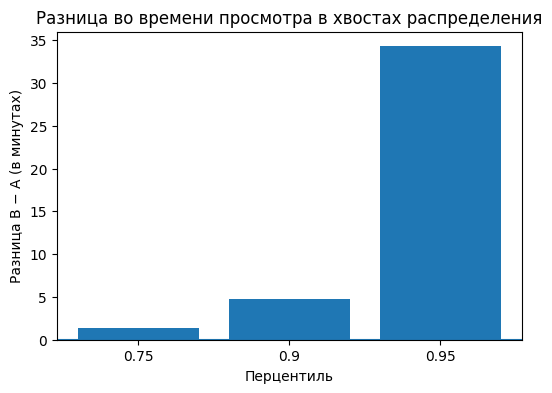

In [13]:
plt.figure(figsize=(6, 4))
plt.bar([str(p) for p in percentiles], diffs)
plt.axhline(0)
plt.xlabel("Перцентиль")
plt.ylabel("Разница B − A (в минутах)")
plt.title("Разница во времени просмотра в хвостах распределения")
plt.show()

## Статистические гипотезы

__Для теста Манна–Уитни:__
1. H₀: распределения общего времени просмотра пользователей в группах A и B одинаковы.
2. H₁: распределения общего времени просмотра пользователей в группах A и B различаются.

## Интерпретация p-value

1. Если p-value < 0.05, нулевая гипотеза отвергается: между группами A и B существует статистически значимое различие.
2. Если p-value ≥ 0.05, оснований отвергнуть нулевую гипотезу нет.
> Однозначный вывод о превосходстве алгоритма B на основании полученного p-value сделать нельзя. Так как p-value < 0.05, но очень близок (p-value = 0.045342), то тест фиксирует различие распределений, но не доказывает, что алгорит B лучше A.

## Итоговый вывод:
1. Эффективность алгоритма B
    > По результатам теста Манна–Уитни получено значение p-value < 0.05 (p-value = 0.045342), что указывает на значимое различие распределений общего времени просмотра между группами A и B. Однако, поскольку использован U-тест, данный результат показывает лишь наличие различий, но не доказывает превосходство алгоритма B над алгоритмом A по всей аудитории.  


2. Группа пользователей с наибольшим эффектом  
    Анализ процентилей показал, что:
    - на 75-м перцентиле значение в группе B превышает значение группы A;
    - на 90-м перцентиле разница между группами увеличивается;
    - на 95-м перцентиле наблюдается наибольший положительный разрыв в пользу группы B.

    > Это означает, что эффект нового алгоритма усиливается в правом хвосте распределения и в наибольшей степени проявляется у активных пользователей и “супер-зрителей”, тогда как для пользователей с низким временем просмотра различия минимальны.  


3. Наиболее информативный метод анализа:
    > Анализ хвостов распределения (процентили) оказался наиболее информативным, так как эффект алгоритма B проявляется асимметрично и не выражен равномерным сдвигом всего распределения.  


4. Рекомендация по запуску алгоритма
    > Целесообразно сегментированный запуск алгоритма B, ориентированный на активных пользователей, а не немедленное внедрение на всю аудиторию